In [44]:
from collections import namedtuple
import glob
from itertools import product
import logging
import os
import random

import soundfile as sf
from pyrubberband import pyrb
import argparse
import librosa.effects
import librosa.core
import numpy as np
import pydub
import tensorflow as tf

from audio_load import load_audio_from_files, audio2spec
from st_2d import scat2d
import windows as win

In [45]:
import matplotlib.pyplot as plt
import IPython.display as ipd
import librosa.display

In [46]:
sr=16000

In [47]:
def load_data(p_files):    
    
    p_samples = load_audio_from_files(p_files, "wav", 3000, 8000)
    p_specs = audio2spec(p_samples, 160, 80, 640)
    p_labels = np.ones(len(p_samples))
    
    return p_samples, p_specs, p_labels

In [48]:
# n_files = glob.glob('/scratch0/ilya/locDoc/data/alexa/v1/libri_3s/dev-clean/*/*/*.wav')[:5]
# p_files = glob.glob('/scratch0/ilya/locDoc/data/alexa/v1/alexa_8khz/*/*.wav')[::10]

In [49]:
n_files = glob.glob('/scratch1/ilya/locDoc/data/LibriSpeech/train-clean-100/*/*/*.flac')[::1000]
p_files = glob.glob('/scratch0/ilya/locDoc/data/alexa/v1/alexa/*/*.wav')[::10]

In [50]:
n_files = glob.glob('../data/LibriSpeech/train-clean-100/*/*/*.flac')[::1000]
p_files = glob.glob('../data/alexa/*/*.wav')[::10]

In [51]:
len(n_files)

29

In [52]:
samples_bg, _ = sf.read(n_files[0])

Text(0.5, 1.0, 'Source Other Speech')

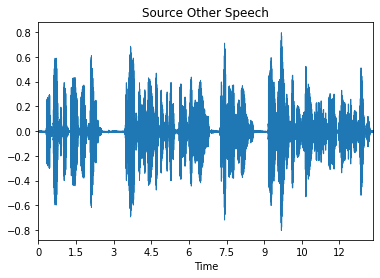

In [53]:
librosa.display.waveplot(samples_bg, sr=sr)
plt.title('Source Other Speech')

In [54]:
ipd.Audio(samples_bg, rate=sr)

In [55]:
# split into sentences
audio_chunks = librosa.effects.split(samples_bg, top_db=60, frame_length=320, hop_length=160)
chunk_lens = [(chunk[1] - chunk[0]) / float(sr) for chunk in audio_chunks]
sentence_chunks = [chunk for chunk in audio_chunks if ((chunk[1] - chunk[0]) / float(sr)) > 0.5]
len(sentence_chunks)

1

In [56]:
def get_chunk(samples, chunk):
    return np.array(samples[chunk[0]:chunk[1]])

Text(0.5, 1.0, 'Source Other Speech')

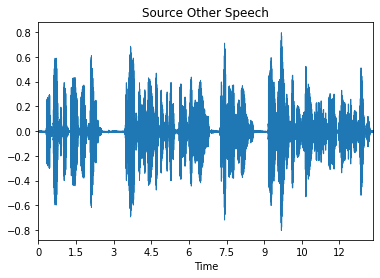

In [57]:
sentence = get_chunk(samples_bg, sentence_chunks[0])
librosa.display.waveplot(sentence, sr=sr)
plt.title('Source Other Speech')

In [58]:
samples, _ = sf.read(p_files[0])
samples_trimmed, index = librosa.effects.trim(samples, top_db=20)

Text(0.5, 1.0, 'Source Wakeword')

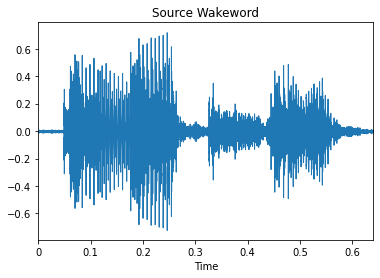

In [59]:
librosa.display.waveplot(samples_trimmed, sr=sr)
plt.title('Source Wakeword')

In [60]:
ipd.Audio(samples_trimmed, rate=sr)

In [61]:
specs = audio2spec(np.expand_dims(samples_trimmed, 0) , sr // 50, sr // 100, sr // 50)

100%|██████████| 1/1 [00:00<00:00, 359.19it/s]


Text(0.5, 1.0, 'Source Wakeword')

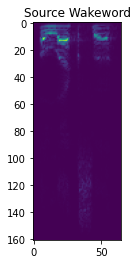

In [62]:
plt.figure()
plt.imshow(specs[0])
plt.title('Source Wakeword')

In [63]:
samples_timealtered = pyrb.time_stretch(samples, sr=sr, rate=1.5)
samples_timealtered_, _ = librosa.effects.trim(samples_timealtered, top_db=20)
ipd.Audio(samples_timealtered_, rate=sr)

100%|██████████| 1/1 [00:00<00:00, 649.17it/s]


Text(0.5, 1.0, 'Time Altered Wakeword')

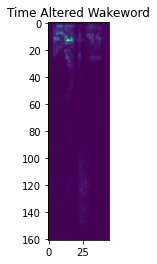

In [64]:
specs = audio2spec(np.expand_dims(samples_timealtered_, 0) , sr // 50, sr // 100, sr // 50)
plt.figure()
plt.imshow(specs[0])
plt.title('Time Altered Wakeword')

In [65]:
samples_pitchaltered = pyrb.pitch_shift(samples_timealtered, sr=sr, n_steps=-2.5)
samples_pitchaltered_, _ = librosa.effects.trim(samples_pitchaltered, top_db=20)
ipd.Audio(samples_pitchaltered_, rate=sr)

100%|██████████| 1/1 [00:00<00:00, 504.43it/s]


Text(0.5, 1.0, 'Time and Pitch Altered Wakeword')

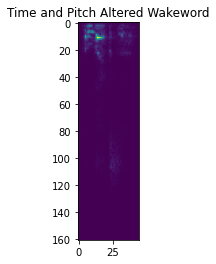

In [66]:
specs = audio2spec(np.expand_dims(samples_pitchaltered_, 0) , sr // 50, sr // 100, sr // 50)
plt.figure()
plt.imshow(specs[0])
plt.title('Time and Pitch Altered Wakeword')

In [67]:
def mix_two(a_,b, b_advance=0):
    a = np.copy(a_)
    if len(b) <= b_advance:
        a[-b_advance:(len(b)-b_advance)] += b
        return a
    else:
        if b_advance > 0:
            a[-b_advance:] += b[:b_advance]
            return np.concatenate([a, b[b_advance:]], axis=0)
        else:
            return np.concatenate([a, b], axis=0)
    

def mix_three(a, b, c, b_advance=320, c_advance=320, output_advance=0, output_len=32000):
    """
     b_advance
          <---
         ^ default output start is whenever B starts
    |---A-----|---B---|----C-----|
                   <--
             c_advance^
    output_advance advances the default output start.
    """
    ab = mix_two(a,b,b_advance)
    abc = mix_two(ab,c,c_advance)
    s = len(a)-b_advance - output_advance
    e = s + output_len
    return abc[s:e]


In [68]:
mixed = mix_three(get_chunk(samples_bg, sentence_chunks[0]), np.array(samples_pitchaltered_), get_chunk(samples_bg, sentence_chunks[1]), b_advance=20*sr//50, c_advance=15*sr//50, output_advance=30*sr//50)
ipd.Audio(mixed, rate=sr)

IndexError: list index out of range

In [ ]:
def audio_augment(leading,wakeword,trailing, sr, time_stretch=1.0, pitch_shifts=0, b_advance=320, c_advance=320, output_advance=0, output_len=32000):
    """
    leading, trailing: should be trimmed np.arrays
    wakeword: should not be trimmed, regular array
    time_stretch: float
    pitch_shifts: signed int
    
    see mix_three for other args.
    """
    wakeword_timealtered = pyrb.time_stretch(wakeword, sr=sr, rate=time_stretch)
    wakeword_pitchaltered = pyrb.pitch_shift(wakeword_timealtered, sr=sr, n_steps=pitch_shifts)
    wakeword_pitchaltered_, _ = librosa.effects.trim(wakeword_pitchaltered, top_db=20)
    return mix_three(leading, np.array(wakeword_pitchaltered_), trailing, b_advance=b_advance, c_advance=c_advance, output_advance=output_advance, output_len=output_len)


In [ ]:
time_stretch_opts = np.arange(0.8,1.25,.05).tolist()
pitch_shift_opts = np.arange(-3,3.5,0.5).tolist()
b_advance_opts = np.arange(0, sr//2, sr//20, dtype=int).tolist()
c_advance_opts = np.arange(0, sr//4, sr//20, dtype=int).tolist()
output_advance_opts = np.arange(sr//10, sr, sr//10, dtype=int).tolist()
augment_opts = list(product(*[time_stretch_opts, pitch_shift_opts, b_advance_opts, c_advance_opts, output_advance_opts]))

In [ ]:
time_stretch, pitch_shifts, b_advance, c_advance, output_advance, = augment_opts[random.randint(0,len(augment_opts)-1)]

In [ ]:
time_stretch, pitch_shifts, b_advance, c_advance, output_advance

In [ ]:
mixed = audio_augment(get_chunk(samples_bg, sentence_chunks[0]), np.array(samples_pitchaltered_), get_chunk(samples_bg, sentence_chunks[1]), sr, time_stretch, pitch_shifts, b_advance, c_advance, output_advance)
ipd.Audio(mixed, rate=sr)

In [ ]:
def augment_audio(p_file, n_file, time_stretch, pitch_shifts, b_advance, c_advance, output_advance):
    sr = 16000
    output_len = 32000
    samples_bg, _ = sf.read(n_file)
    # split into sentences
    audio_chunks = librosa.effects.split(samples_bg, top_db=60, frame_length=320, hop_length=160)
    chunk_lens = [(chunk[1] - chunk[0]) / float(sr) for chunk in audio_chunks]
    sentence_chunks = [chunk for chunk in audio_chunks if ((chunk[1] - chunk[0]) / float(sr)) > 0.3]
    def get_chunk(samples, chunk):
        return np.array(samples[chunk[0]:chunk[1]])
    if len(sentence_chunks) < 2:
        sentence_chunks = [[len(samples_bg)//2, len(samples_bg)-1],[0,len(samples_bg)//2]]
    leading_chunk, trailing_chunk = random.sample(sentence_chunks, 2)
    leading = get_chunk(samples_bg, leading_chunk)
    trailing = get_chunk(samples_bg, trailing_chunk)
        
    wakeword, _ = sf.read(p_file)
    wakeword_timealtered = pyrb.time_stretch(wakeword, sr=sr, rate=time_stretch)
    wakeword_pitchaltered = pyrb.pitch_shift(wakeword_timealtered, sr=sr, n_steps=pitch_shifts)
    wakeword_pitchaltered_, _ = librosa.effects.trim(wakeword_pitchaltered, top_db=20)
    return mix_three(leading, np.array(wakeword_pitchaltered_), trailing, b_advance=b_advance, c_advance=c_advance, output_advance=output_advance, output_len=output_len)
    

In [ ]:
mixed = augment_audio(p_files[1], n_files[2], time_stretch, pitch_shifts, b_advance, c_advance, output_advance)
ipd.Audio(mixed, rate=sr)